# Загрузка Pandas и просмотр данных

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
from itertools import combinations
import scipy.stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import ttest_ind
import time 

In [2]:
df = pd.read_csv('main_task.csv')
df_original = pd.read_csv('main_task.csv')
df.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [3]:
# Посмотрим какие данные представлены в датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


У нас есть 3 столбца с числовыми значениями, остальные со строковыми. Столбец Price Range содержит интервальные данные, позже мы их преобразуем. Из столбца Reviews также сможем выделить числовые значения, такие как "длина комментариев" и "дата". Из столбца Cuisine Slyle получим числовое значение кол-ва представленных кухонь.

In [4]:
# Посмотрим кол-во пропусков по столбцам
df.isna().sum()

Restaurant_id            0
City                     0
Cuisine Style         9283
Ranking                  0
Rating                   0
Price Range          13886
Number of Reviews     2543
Reviews                  0
URL_TA                   0
ID_TA                    0
dtype: int64

# Работа с попусками

In [5]:
# Заполним пропуски

# Дальше мы будем менять категоральные признаки на числовые, поэтому Price Range я заполняю 0
df['Price Range'].fillna(0, inplace=True) 

# По условию задачи, не отмеченная кухня в ресторане считается единичной, дадим ей собственную категорию
df['Cuisine Style'] = df['Cuisine Style'].fillna("'Unknown'") 

# Здесь я подразумеваю, что отзывов нет, поэтому также заполняю 0
df['Number of Reviews'].fillna(0, inplace=True) 

# В столбце Reviews есть пустые значения, их обработка будет производится дальше

# Обработка признаков

In [6]:
pd.set_option('mode.chained_assignment', None) # Чтобы не ругался

# Создадим словарь со списком всех кухонь на всякий случай
cuisines_dict = {} 

# Создадим новый столбец с кол-вом кухонь у ресторана
df['Cuisine Quantity'] = 0 

# Заполняем новый столбец, заодно и словарь
for i in range(0, len(df['Cuisine Style'])):
    cuisines = df['Cuisine Style'][i][1:-1].split(', ')
    df['Cuisine Style'][i] = pd.Series(cuisines)
    df['Cuisine Quantity'][i] = len(list(cuisines))
    
    for j in range(0, len(cuisines)):
        cuisines_dict.setdefault(cuisines[j][1:-1])

# Исправляем ошибку преобразования в цикле для 1 позиции в словаре
cuisines_dict['Unknown'] = cuisines_dict.pop('nknow')

In [7]:
# Получим спиcок всех дат и запишем разницу в днях между ними в новый столбец.
# Среднюю длину отзывов запишем также в новый столбец
start_time = time.time()

df['Reviews Interval'] = None
df['Reviews Lenght'] = None

# Цикл разделяет строку на отзывы и даты, затем разделяет значения, складывает значения в ДФ
for i in range(0, len(df['Reviews'])):
    inc_reviews = df['Reviews'][i][2:-2].split('], [')[0]
    inc_dates = df['Reviews'][i][2:-2].split('], [')[1]
    datelist = inc_dates.split(', ')
    res_dates = []
    res_len_reviews = []
    for j in range(0, len(datelist)):
        if datelist == ['']: 
            res_len_reviews.append(0)
            res_dates.append(0)
        else:
            review = inc_reviews.split(', ')[j][1:-1]
            res_len_reviews.append(len(review))
            date = datetime.strptime(datelist[j], "'%m/%d/%Y'") # приводит к datetime
            res_dates.append(date)
    df['Reviews Lenght'][i] = np.array(res_len_reviews).mean()
    df['Reviews Interval'][i] = res_dates

# Цикл преобазует значения дат в разницу дней
for i in range(0, len(df['Reviews Interval'])):
    if df['Reviews Interval'][i] == [] or len(df['Reviews Interval'][i]) == 1: df['Reviews Interval'][i] = 0
    else: df['Reviews Interval'][i] = (abs(df['Reviews Interval'][i][0] - df['Reviews Interval'][i][1])).days
        
print("--- %s seconds ---" % (time.time() - start_time))

--- 27.137460470199585 seconds ---


In [8]:
# Заменим значения Price Range на числовые
price_dict = {'$': 1, '$$ - $$$': 2, '$$$$': 3}
df['Price Range'] = df['Price Range'].replace(to_replace=price_dict)

In [9]:
# Создадим dummy variables для видов кухонь
dummies = pd.get_dummies(df['Cuisine Style'].explode())
dummies = dummies.groupby(dummies.index).sum().reset_index()
dummies.drop(['index'], axis='columns', inplace=True)
df = df.join(dummies)

In [10]:
# Тоже самое сделаем для городов
df = pd.get_dummies(df, columns=[ 'City',], dummy_na=True)

In [11]:
# Посмотрим, что получается
pd.set_option('display.max_columns', None)
df.head(5)

,Restaurant_id,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,Cuisine Quantity,Reviews Interval,Reviews Lenght,'Afghani','African','Albanian','American','Arabic','Argentinean','Armenian','Asian','Australian','Austrian','Azerbaijani','Balti','Bangladeshi','Bar','Barbecue','Belgian','Brazilian','Brew Pub','British','Burmese','Cafe','Cajun & Creole','Cambodian','Canadian','Caribbean','Caucasian','Central American','Central Asian','Central European','Chilean','Chinese','Colombian','Contemporary','Croatian','Cuban','Czech','Danish','Delicatessen','Diner','Dutch','Eastern European','Ecuadorean','Egyptian','Ethiopian','European','Fast Food','Filipino','French','Fujian','Fusion','Gastropub','Georgian','German','Gluten Free Options','Greek','Grill','Halal','Hawaiian','Healthy','Hungarian','Indian','Indonesian','International','Irish','Israeli','Italian','Jamaican','Japanese','Korean','Kosher','Latin','Latvian','Lebanese','Malaysian','Mediterranean','Mexican','Middle Eastern','Minority Chinese','Mongolian','Moroccan','Native American','Nepali','New Zealand','Norwegian','Pakistani','Persian','Peruvian','Pizza','Polish','Polynesian','Portuguese','Pub','Romanian','Russian','Salvadoran','Scandinavian','Scottish','Seafood','Singaporean','Slovenian','Soups','South American','Southwestern','Spanish','Sri Lankan','Steakhouse','Street Food','Sushi','Swedish','Swiss','Taiwanese','Thai','Tibetan','Tunisian','Turkish','Ukrainian','Uzbek','Vegan Options','Vegetarian Friendly','Venezuelan','Vietnamese','Welsh','Wine Bar','Xinjiang','Yunnan',Unknown,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,City_Budapest,City_Copenhagen,City_Dublin,City_Edinburgh,City_Geneva,City_Hamburg,City_Helsinki,City_Krakow,City_Lisbon,City_Ljubljana,City_London,City_Luxembourg,City_Lyon,City_Madrid,City_Milan,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
0,id_5569,0 'European' 1 'French' 2 ...,5570.0,3.5,2,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,3,41,24.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,id_1535,0 Unknown dtype: object,1537.0,4.0,0,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,1,382,18.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,id_352,0 'Japanese' 1 ...,353.0,4.5,3,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,7,2,18,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,id_3456,0 Unknown dtype: object,3458.0,5.0,0,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,id_615,0 'German' 1 'Central Eu...,621.0,4.0,2,84.0,"[['Best place to try a Bavarian food', 'Nice 

# Обогащение

In [12]:
# В приступе отсутствия лени, добавим в датасет информацию о населении городов.
# Для этого используем скачанный на Kaggle датасет World Cities 2019 года выпуска.
cities = pd.read_csv('worldcities.csv')
cities

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Malishevë,Malisheve,42.4822,20.7458,Kosovo,XK,XKS,Malishevë,admin,NaN,1901597212
1,Prizren,Prizren,42.2139,20.7397,Kosovo,XK,XKS,Prizren,admin,NaN,1901360309
2,Zubin Potok,Zubin Potok,42.9144,20.6897,Kosovo,XK,XKS,Zubin Potok,admin,NaN,1901608808
3,Kamenicë,Kamenice,42.5781,21.5803,Kosovo,XK,XKS,Kamenicë,admin,NaN,1901851592
4,Viti,Viti,42.3214,21.3583,Kosovo,XK,XKS,Viti,admin,NaN,1901328795
...,...,...,...,...,...,...,...,...,...,...,...
12954,Sturgis,Sturgis,44.4111,-103.4975,United States,US,USA,South Dakota,NaN,6862.0,1840002174
12955,Tea,Tea,43.4515,-96.8346,United States,US,USA,South Dakota,NaN,5415.0,1840002841
12956,Brandon,Brandon,43.5928,-96.5799,United States,US,USA,South Dakota,NaN,9263.0,1840002650
12957,Madison,Madison,44.0062,-97.1084,United States,US,USA,South Dakota,NaN,6983.0,1840002540


In [13]:
# Проверим, все ли наши города присутствуют в нем.
city_to_check = pd.DataFrame(df_original['City'].unique())
result = city_to_check.isin(cities.city_ascii.unique())
city_to_check[result == False].dropna() # Посмотрим кто отуствует

,0
5,Oporto
17,Copenhagen


In [14]:
# Постотрим сколько раз названия наших городов втсречаются в датасете WC
for i in range(len(city_to_check[0])):
    if city_to_check[0][i] in cities.city_ascii.unique():
        display(cities[cities.city_ascii == city_to_check[0][i]])

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
6735,Paris,Paris,48.8667,2.3333,France,FR,FRA,Île-de-France,primary,9904000.0,1250015082
9269,Paris,Paris,33.6689,-95.5462,United States,US,USA,Texas,NaN,25961.0,1840020594
9624,Paris,Paris,36.2934,-88.3065,United States,US,USA,Tennessee,NaN,10576.0,1840014438
11088,Paris,Paris,39.6148,-87.6904,United States,US,USA,Illinois,NaN,8431.0,1840009542
12816,Paris,Paris,38.2015,-84.2717,United States,US,USA,Kentucky,NaN,12662.0,1840014315


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
2794,Stockholm,Stockholm,59.3508,18.0973,Sweden,SE,SWE,Stockholm,primary,1264000.0,1752425602


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
5327,London,London,42.9700,-81.2500,Canada,CA,CAN,Ontario,NaN,346765.0,1124469960
6959,London,London,51.5000,-0.1167,United Kingdom,GB,GBR,NaN,primary,8567000.0,1826645935
11904,London,London,39.8936,-83.4374,United States,US,USA,Ohio,NaN,14597.0,1840000674
12841,London,London,37.1209,-84.0804,United States,US,USA,Kentucky,NaN,37424.0,1840015258


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
6302,Berlin,Berlin,52.5218,13.4015,Germany,DE,DEU,Berlin,primary,3406000.0,1276451290
8725,Berlin,Berlin,44.4869,-71.2599,United States,US,USA,New Hampshire,NaN,11351.0,1840002100
8848,Berlin,Berlin,39.7915,-74.9375,United States,US,USA,New Jersey,NaN,7606.0,1840001505


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
6304,Munich,Munich,48.1299,11.575,Germany,DE,DEU,Bavaria,admin,1275000.0,1276692352


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
7778,Milan,Milan,45.4700,9.2050,Italy,IT,ITA,Lombardy,admin,2945000.0,1380724377
9610,Milan,Milan,35.9126,-88.7556,United States,US,USA,Tennessee,NaN,7253.0,1840014483
10827,Milan,Milan,41.4416,-90.5595,United States,US,USA,Illinois,NaN,5061.0,1840011444
12550,Milan,Milan,42.0816,-83.6854,United States,US,USA,Michigan,NaN,7787.0,1840003170


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
3031,Bratislava,Bratislava,48.15,17.117,Slovakia,SK,SVK,Bratislavský,primary,423737.0,1703195001


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
4250,Vienna,Vienna,48.2000,16.3666,Austria,AT,AUT,Wien,primary,2400000.0,1040261752
8273,Vienna,Vienna,38.8996,-77.2597,United States,US,USA,Virginia,NaN,16544.0,1840003829
8481,Vienna,Vienna,39.3238,-81.5383,United States,US,USA,West Virginia,NaN,10370.0,1840005787


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
7765,Rome,Rome,41.8960,12.4833,Italy,IT,ITA,Lazio,primary,3339000.0,1380382862
9695,Rome,Rome,43.2260,-75.4909,United States,US,USA,New York,NaN,32185.0,1840000349
11181,Rome,Rome,34.2662,-85.1862,United States,US,USA,Georgia,NaN,60966.0,1840014681


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
3799,Barcelona,Barcelona,10.1304,-64.7200,Venezuela,VE,VEN,Anzoátegui,admin,600954.0,1862418619
6582,Barcelona,Barcelona,41.3833,2.1834,Spain,ES,ESP,Catalonia,admin,4920000.0,1724594040


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
6624,Madrid,Madrid,40.4,-3.6834,Spain,ES,ESP,Madrid,primary,5567000.0,1724616994


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
7429,Dublin,Dublin,53.3331,-6.2489,Ireland,IE,IRL,Dublin,primary,1059000.0,1372595407
10360,Dublin,Dublin,37.7161,-121.8964,United States,US,USA,California,NaN,60939.0,1840018916
11216,Dublin,Dublin,32.5357,-82.9279,United States,US,USA,Georgia,NaN,20493.0,1840013813
11958,Dublin,Dublin,40.1111,-83.1452,United States,US,USA,Ohio,NaN,47619.0,1840008389


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
4568,Brussels,Brussels,50.8333,4.3333,Belgium,BE,BEL,Brussels-Capital Region,primary,1743000.0,1056469830


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
5580,Zürich,Zurich,47.38,8.55,Switzerland,CH,CHE,Zürich,admin,1108000.0,1756539143


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
1852,Warsaw,Warsaw,52.2500,21.0000,Poland,PL,POL,Mazowieckie,primary,1707000.0,1616024847
11407,Warsaw,Warsaw,41.2443,-85.8479,United States,US,USA,Indiana,NaN,32813.0,1840010277


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
7281,Budapest,Budapest,47.5,19.0833,Hungary,HU,HUN,Budapest,primary,1679000.0,1348611435


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
1410,Amsterdam,Amsterdam,52.350,4.9166,Netherlands,NL,NLD,Noord-Holland,primary,1031000.0,1528355309
9771,Amsterdam,Amsterdam,42.942,-74.1907,United States,US,USA,New York,NaN,21334.0,1840000391


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
6743,Lyon,Lyon,45.77,4.83,France,FR,FRA,Auvergne-Rhône-Alpes,admin,1423000.0,1250196189


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
6314,Hamburg,Hamburg,53.5500,10.0000,Germany,DE,DEU,Hamburg,admin,1757000.0,1276041799
9720,Hamburg,Hamburg,42.7233,-78.8348,United States,US,USA,New York,NaN,9696.0,1840004385


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
1860,Lisbon,Lisbon,38.7227,-9.1449,Portugal,PT,PRT,Lisboa,primary,2812000.0,1620619017
11806,Lisbon,Lisbon,40.7752,-80.7628,United States,US,USA,Ohio,NaN,5439.0,1840011932


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
6293,Prague,Prague,50.0833,14.466,Czechia,CZ,CZE,"Praha, Hlavní Město",primary,1162000.0,1203744823


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
1427,Oslo,Oslo,59.9167,10.75,Norway,NO,NOR,Oslo,primary,835000.0,1578324706


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
6678,Helsinki,Helsinki,60.1756,24.9341,Finland,FI,FIN,Uusimaa,primary,1115000.0,1246177997


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
6814,Edinburgh,Edinburgh,55.9483,-3.2191,United Kingdom,GB,GBR,"Edinburgh, City of",admin,504966.0,1826492520


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
5594,Geneva,Geneva,46.2100,6.1400,Switzerland,CH,CHE,Genève,admin,1240000.0,1756810813
9861,Geneva,Geneva,42.8644,-76.9827,United States,US,USA,New York,NaN,29140.0,1840000393
11133,Geneva,Geneva,41.8833,-88.3243,United States,US,USA,Illinois,NaN,22010.0,1840008135
12033,Geneva,Geneva,41.8007,-80.9461,United States,US,USA,Ohio,NaN,7364.0,1840008145


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
2818,Ljubljana,Ljubljana,46.0553,14.515,Slovenia,SI,SVN,Ljubljana,primary,314807.0,1705917455


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
7145,Athens,Athens,37.9833,23.7333,Greece,GR,GRC,Attikí,primary,3242000.0,1300715560
9021,Athens,Athens,32.2053,-95.8348,United States,US,USA,Texas,NaN,12163.0,1840019500
9650,Athens,Athens,35.4573,-84.6042,United States,US,USA,Tennessee,NaN,16170.0,1840013429
10701,Athens,Athens,34.7847,-86.9510,United States,US,USA,Alabama,NaN,29192.0,1840000935
11240,Athens,Athens,33.9508,-83.3689,United States,US,USA,Georgia,NaN,140169.0,1840029463
11823,Athens,Athens,39.3269,-82.0988,United States,US,USA,Ohio,NaN,29926.0,1840007355


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
436,Luxembourg,Luxembourg,49.6117,6.13,Luxembourg,LU,LUX,Luxembourg,primary,107260.0,1442262731


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
1843,Kraków,Krakow,50.06,19.96,Poland,PL,POL,Małopolskie,admin,756000.0,1616172264


In [15]:
# Видно что дубликаты городов: 28 из US, 1 из VE, 1 из CA.
# Можно смело минусануть все города из данных стран, т.к. наших городов в этих странах нет.
to_del = cities[cities.iso2.isin(['US','VE','CA'])]
cities = cities[~cities.index.isin(to_del.index)]

In [16]:
# Получим значения population для наших городов
pop = []
our_cities = city_to_check[0].tolist()

for i in range(len(city_to_check[0])):
    if city_to_check[0][i] in cities.city_ascii.unique():
        pop.append(int(cities[cities.city_ascii == city_to_check[0][i]].population.values[0]))
    else:
        pop.append(0)

population_dict = dict(zip(our_cities, pop))

# Заполним пропуски данными из Википедии
missed_cities = {'Oporto': 214349,'Copenhagen': 602481}
population_dict.update(missed_cities)

In [17]:
# Добавим в рабочий датафрейм данные о населении
df['City Population'] = 0

for i in range(len(df)):
    df['City Population'][i] += population_dict.get(df_original['City'][i])

In [18]:
# Финальная проверка на пропуски
df.isna().sum().sum()

0

# Анализ данных

In [19]:
# Проверим распределение признака Ranking на нормальность
# Проведем тест Шапиро-Уилка
import scipy
stat, p = scipy.stats.shapiro(df_original['Ranking'])
print('Statistics=%.3f, p-value=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Нормальное распределение признака')
else:
    print('Ненормальное распределение признака')

Statistics=0.827, p-value=0.000
Ненормальное распределение признака


C:\Anaconda\lib\site-packages\scipy\stats\morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


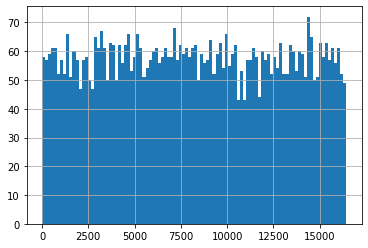

In [20]:
# Посмотрим на его распределение в ТОП1 городе 
df_original['Ranking'][df_original['City'] =='London'].hist(bins=100)

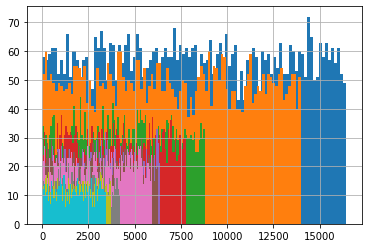

In [21]:
# Посмотрим на его распределение в ТОП10 городах
for top10cities in df_original['City'].value_counts()[0:10].index:
    df_original['Ranking'][df_original['City'] == top10cities].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение. (Списал с ноутубка Kaggle)

In [22]:
# Сделаем тест Стьюдента
def get_stat_dif(column):
    cols = df.loc[:, column].value_counts().index[:50]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'Rating'],
                     df.loc[df.loc[:, column] == comb[1], 'Rating']).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [23]:
for col in ['Ranking', 'Price Range', 'Number of Reviews', 'Cuisine Quantity', 'Reviews Interval', 'Reviews Lenght']:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки Price Range
Найдены статистически значимые различия для колонки Number of Reviews
Найдены статистически значимые различия для колонки Cuisine Quantity
Найдены статистически значимые различия для колонки Reviews Interval
Найдены статистически значимые различия для колонки Reviews Lenght


Забираем эти столбцы в модель.

In [24]:
# Соберем модель для корреляции, исключая кухни (их очень много)
corr_model = df[df.columns[:12]].join(df[df.columns[-32:]])

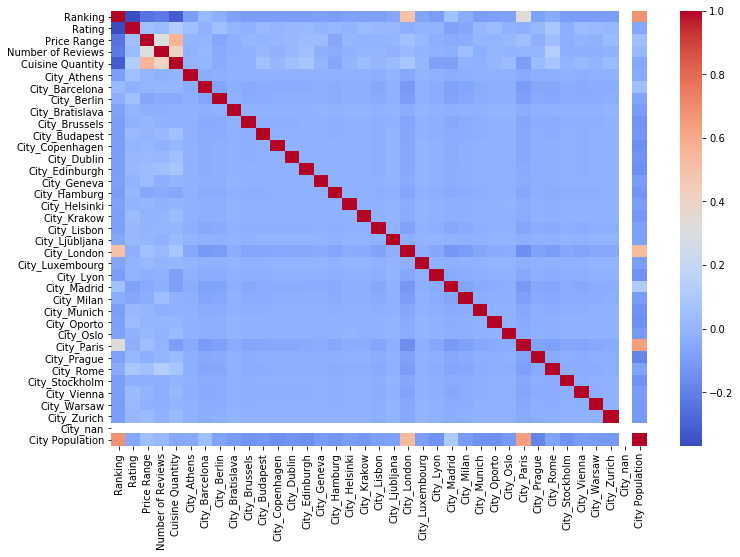

In [25]:
plt.rcParams['figure.figsize'] = (12,8)
sns.heatmap(corr_model.corr(),cmap='coolwarm')

Из тепловой карты корреляции становится понятно, что:<br>

1) Самые высокий Ranking (= больше низкорейтинговых заведений) в Лондоне и Париже (потомучто больше всего данных именно оттуда)<br>
2) Чем больше кухонь представлено в ресторане, тем выше у него диапозон цены<br>
3) У ресторанов с большим кол-вом кухонь большее кол-во отзывов и меньше Ranking (что лучше)<br>
4) Чем город больше, тем больше в нем ресторанов (что не удивительно) и выше Ranking (что хуже)<br><br>
Выводы:<br>
В крупных городах численно больше заведений с маленьким набором кухонь, низким Ranking'ом. Подозреваю что это связано с туристическим потоком в этих городах. Но проверять гипотезу уже нет сил. Простите.



# Подготовка модели

In [26]:
# Удалим столбцы типа Object
model = df
model.drop(['Restaurant_id','Cuisine Style','Reviews','URL_TA','ID_TA'], axis='columns', inplace=True)

In [27]:
# Нормализуем все признаки и целевую переменную

scaler = MinMaxScaler()

def normalizer(df):
    for i in range(0,len(df.columns)):
        if type(df[df.columns[i]][0]) != type('str'):
            to_norm = np.array(df[df.columns[i]]).reshape(-1, 1)
            df[df.columns[i]] = scaler.fit_transform(to_norm)  
        else: 
            continue

normalizer(model)
model

,Ranking,Rating,Price Range,Number of Reviews,Cuisine Quantity,Reviews Interval,Reviews Lenght,'Afghani','African','Albanian','American','Arabic','Argentinean','Armenian','Asian','Australian','Austrian','Azerbaijani','Balti','Bangladeshi','Bar','Barbecue','Belgian','Brazilian','Brew Pub','British','Burmese','Cafe','Cajun & Creole','Cambodian','Canadian','Caribbean','Caucasian','Central American','Central Asian','Central European','Chilean','Chinese','Colombian','Contemporary','Croatian','Cuban','Czech','Danish','Delicatessen','Diner','Dutch','Eastern European','Ecuadorean','Egyptian','Ethiopian','European','Fast Food','Filipino','French','Fujian','Fusion','Gastropub','Georgian','German','Gluten Free Options','Greek','Grill','Halal','Hawaiian','Healthy','Hungarian','Indian','Indonesian','International','Irish','Israeli','Italian','Jamaican','Japanese','Korean','Kosher','Latin','Latvian','Lebanese','Malaysian','Mediterranean','Mexican','Middle Eastern','Minority Chinese','Mongolian','Moroccan','Native American','Nepali','New Zealand','Norwegian','Pakistani','Persian','Peruvian','Pizza','Polish','Polynesian','Portuguese','Pub','Romanian','Russian','Salvadoran','Scandinavian','Scottish','Seafood','Singaporean','Slovenian','Soups','South American','Southwestern','Spanish','Sri Lankan','Steakhouse','Street Food','Sushi','Swedish','Swiss','Taiwanese','Thai','Tibetan','Tunisian','Turkish','Ukrainian','Uzbek','Vegan Options','Vegetarian Friendly','Venezuelan','Vietnamese','Welsh','Wine Bar','Xinjiang','Yunnan',Unknown,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,City_Budapest,City_Copenhagen,City_Dublin,City_Edinburgh,City_Geneva,City_Hamburg,City_Helsinki,City_Krakow,City_Lisbon,City_Ljubljana,City_London,City_Luxembourg,City_Lyon,City_Madrid,City_Milan,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,City Population
0,0.338685,0.625,0.666667,0.020083,0.10,0.012785,0.544444,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
1,0.093414,0.750,0.000000,0.001035,0.00,0.119114,0.411111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.118074
2,0.021407,0.875,1.000000,0.071222,0.30,0.000624,0.400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [28]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = model.drop(['Rating'], axis = 1)
y = model['Rating']

In [29]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [30]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём, обучаем и тестируем модель

In [31]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [32]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [33]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
MAE = metrics.mean_absolute_error(y_test, y_pred)
print('MAE:', MAE)

MAE: 0.05248774999999999


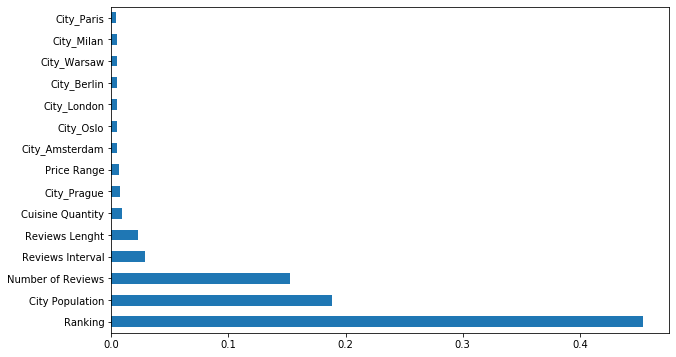

In [34]:
# Оценка влияния признаков на качество модели
plt.rcParams['figure.figsize'] = (10,6)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Применим модель ко всему датафрейму

In [35]:
y_pred = regr.predict(X)

In [36]:
MAE = metrics.mean_absolute_error(y, y_pred)
print('MAE:', MAE)

MAE: 0.027946281249999993


In [37]:
norm_predicted_rating = y_pred + MAE

In [42]:
# Данные в модели нормализованы, для понимания сопоставим данные из модели с оригинальным датасетом
df_original[['Restaurant_id','Rating']][model['Rating'] > norm_predicted_rating]

,Restaurant_id,Rating
7,id_825,3.0
13,id_4637,4.5
15,id_1401,4.0
16,id_5257,4.0
17,id_11121,4.5
...,...,...
39974,id_4650,5.0
39978,id_2188,4.5
39982,id_458,4.5
39990,id_1187,4.5


Вышеуказанные рестораны рекомендованы к проверке на честность, по подозрению в искусственном завышении рейтинга.